## Parcels

In [6]:
import math
from datetime import timedelta
from operator import attrgetter

import matplotlib.pyplot as plt
import numpy as np
import trajan as ta
import xarray as xr
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

import parcels

import netCDF4 as nc
import numpy as np
import pandas as pd
import math
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho  = dataset.variables['lon_rho']
lon_rho = np.transpose(lon_rho, axes=(1, 0))
lat_rho  = dataset.variables['lat_rho']
lat_rho = np.transpose(lat_rho, axes=(1, 0))
z_r = np.load('/home/z5297792/MRes/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))
h = dataset.variables['h']
h = np.transpose(h, (1, 0))
previous_file_idx = -1

In [7]:
fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'

filenames = {
    "U": fname,
    "V": fname,
}
variables = {
    "U": "u_eastward",
    "V": "v_northward",
}
dimensions = {"time": "ocean_time", "lat": "lat_rho", "lon": "lon_rho"}

fieldset = parcels.FieldSet.from_netcdf(filenames, variables, dimensions)

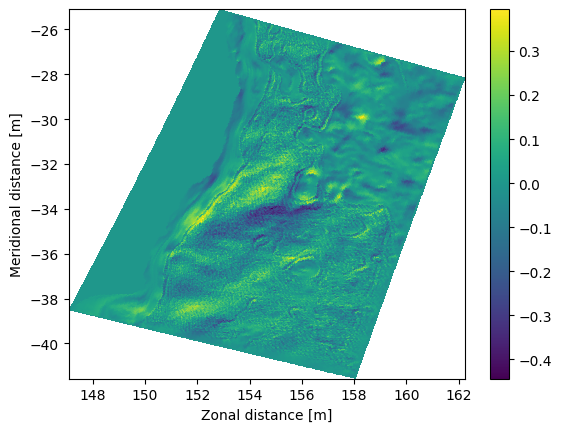

In [8]:
fieldset.computeTimeChunk()

plt.pcolormesh(fieldset.U.grid.lon, fieldset.U.grid.lat, fieldset.U.data[0, :, :])
plt.xlabel("Zonal distance [m]")
plt.ylabel("Meridional distance [m]")
plt.colorbar()
plt.show()

In [9]:
fieldset.time_origin

1994-01-02T00:00:00.000000000

In [17]:
import pickle
with open('ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

In [10]:
# lon = daydic['Day1'].Lon
# lat = daydic['Day1'].Lat

i = list(range(90,180))
j = list(range(70,130))

i = i[::10]
j = j[::10]

i, j = np.meshgrid(i, j)

lon = lon_rho[i,j]
lat = lat_rho[i,j]

In [11]:
pset = parcels.ParticleSet.from_list(
    fieldset=fieldset,  # the fields on which the particles are advected
    pclass=parcels.JITParticle,  # the type of particles (JITParticle or ScipyParticle)
    lon=lon,  # a vector of release longitudes
    lat=lat,  # a vector of release latitudes
)

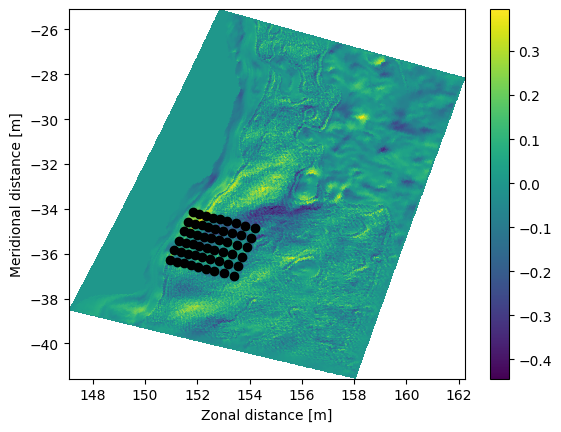

In [12]:
plt.pcolormesh(fieldset.U.grid.lon, fieldset.U.grid.lat, fieldset.U.data[0, :, :])
plt.xlabel("Zonal distance [m]")
plt.ylabel("Meridional distance [m]")
plt.colorbar()

plt.plot(pset.lon, pset.lat, "ko")
plt.show()

In [13]:
output_file = pset.ParticleFile(
    name="EddyParticles.zarr",  # the file name
    outputdt=timedelta(hours=1),  # the time step of the outputs
)
pset.execute(
    parcels.AdvectionRK4,  # the kernel (which defines how particles move)
    runtime=timedelta(days=20),  # the total length of the run
    dt=timedelta(minutes=5),  # the timestep of the kernel
    output_file=output_file,
)

INFO: Output files are stored in EddyParticles.zarr.
100%|██████████| 1728000.0/1728000.0 [00:24<00:00, 69169.74it/s]


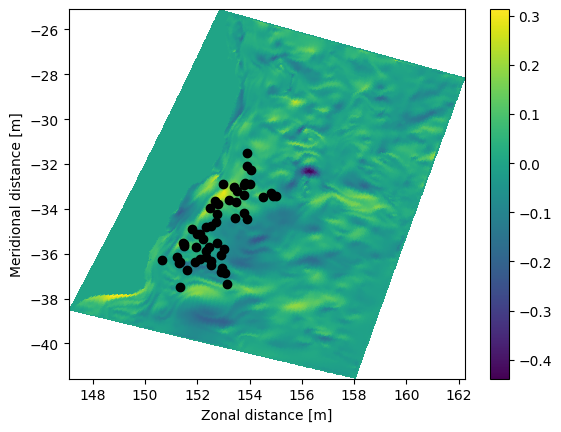

In [14]:
plt.pcolormesh(fieldset.U.grid.lon, fieldset.U.grid.lat, fieldset.U.data[0, :, :])
plt.xlabel("Zonal distance [m]")
plt.ylabel("Meridional distance [m]")
plt.colorbar()

plt.plot(pset.lon, pset.lat, "ko")
plt.show()

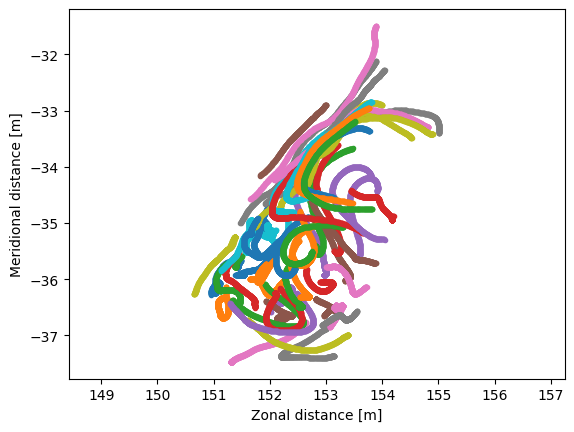

In [16]:
ds = xr.open_zarr("EddyParticles.zarr")

plt.plot(ds.lon.T, ds.lat.T, ".-")
plt.xlabel("Zonal distance [m]")
plt.ylabel("Meridional distance [m]")
plt.axis('equal')
plt.show()

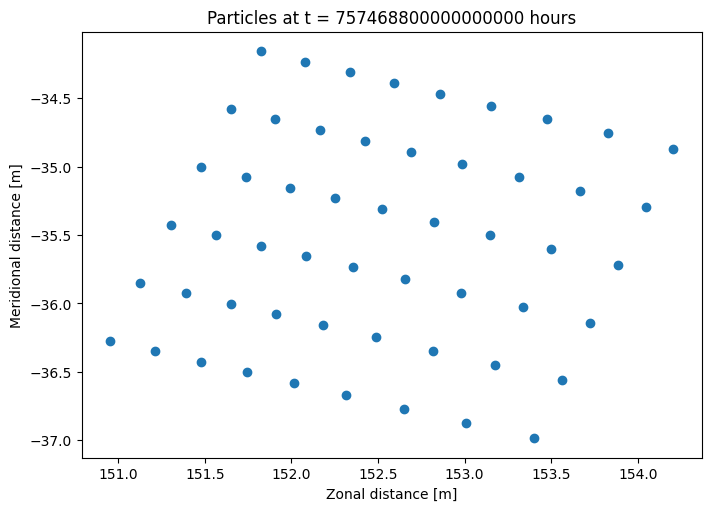

In [56]:
fig = plt.figure(figsize=(7, 5), constrained_layout=True)
ax = fig.add_subplot()

ax.set_ylabel("Meridional distance [m]")
ax.set_xlabel("Zonal distance [m]")
# ax.set_xlim(0, 4e5)
# ax.set_ylim(0, 7e5)

# show only every fifth output (for speed in creating the animation)
timerange = np.unique(ds["time"].values)[::5]

# Indices of the data where time = 0
time_id = np.where(ds["time"] == timerange[0])

sc = ax.scatter(ds["lon"].values[time_id], ds["lat"].values[time_id])

t = str(timerange[0].astype("timedelta64[h]"))
title = ax.set_title(f"Particles at t = {t}")


def animate(i):
    t = str(timerange[i].astype("timedelta64[h]"))
    title.set_text(f"Particles at t = {t}")

    time_id = np.where(ds["time"] == timerange[i])
    sc.set_offsets(np.c_[ds["lon"].values[time_id], ds["lat"].values[time_id]])


anim = FuncAnimation(fig, animate, frames=len(timerange), interval=100)

In [57]:
HTML(anim.to_jshtml())

In [12]:
import math
from datetime import timedelta
from operator import attrgetter

import matplotlib.pyplot as plt
import numpy as np
import trajan as ta
import xarray as xr
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

import parcels

import netCDF4 as nc
import numpy as np
import pandas as pd
import math
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [1]:
fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'

In [13]:

from parcels import FieldSet, Field, AdvectionRK4, ParticleSet, JITParticle, Variable
import numpy as np
from glob import glob
import time as timelib
from datetime import timedelta as delta
from datetime import datetime as datetime
import cartopy
import os
from operator import attrgetter

data_dir = fname

ufiles = fname
vfiles = fname
tfiles = fname

## ######
filenames = {'U': ufiles,
             'V': vfiles,
             'temp': tfiles}

variables = {'U': 'u',
             'V': 'v',
             'temp': 'temp'}

dimensions = {'lon': 'lon_rho', 'lat': 'lat_rho', 'depth': 's_rho', 'time': 'ocean_time'}

indices = {'depth': [29]}

fieldset = parcels.FieldSet.from_netcdf(filenames, variables, dimensions, indices, allow_time_extrapolation=True)#, transpose=True)
fieldset.temp.interp_method = 'nearest'


AttributeError: 'DeferredArray' object has no attribute 'shape'

In [7]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
# Script to import a Croco history file to be used in OceanParcels

from parcels import FieldSet, Field, ParticleSet, JITParticle, AdvectionRK4_3D
from netCDF4 import Dataset
from datetime import timedelta
import numpy as np
from scipy.interpolate import RectBivariateSpline
import os

# # Import files
# pwd = os.path.dirname(os.path.realpath(__file__)) + '/'
# his = pwd + 'croco_avg.nc.1'
# grd = pwd + 'croco_grd.nc.1' 

grd = fname

# Load in coordinates
fh = Dataset(grd, mode='r')
lon_psi = fh.variables['lon_psi'][:]
lat_psi = fh.variables['lat_psi'][:]
lon_rho = fh.variables['lon_rho'][:]
lat_rho = fh.variables['lat_rho'][:]
lon_u = fh.variables['lon_u'][:]
lat_u = fh.variables['lat_u'][:]
lon_v = fh.variables['lon_v'][:]
lat_v = fh.variables['lat_v'][:]
Cs_w = fh.variables['Cs_w'][:] # Stretching function of sigma-w C(s_w)
s_w = fh.dimensions['s_w'] # Sigma coords (w)
s_w_v = fh.variables['s_w'] # Sigma coords (w) (variable-ified)
t = fh.variables['ocean_time'][:]
h = fh.variables['h'][:] # Depth
zeta = fh.variables['zeta'][:]
h_c = fh.variables['hc'] # Vertical stretching parameter
xi_rho = fh.dimensions['xi_rho'] # (x)
eta_rho = fh.dimensions['eta_rho'] # (y)
zdim = s_w.size # Number of vertical points
    
filenames = {'U': {'lon': grd, 'lat': grd, 'depth': grd, 'data': grd}, 
             'V': {'lon': grd, 'lat': grd, 'depth': grd, 'data': grd},
             'W': {'lon': grd, 'lat': grd, 'depth': grd, 'data': grd},
             'Zeta': {'lon': grd, 'lat': grd, 'data': grd}}

variables = {'U': 'u',
             'V': 'v',
             'W': 'w',
             'Zeta': 'zeta'}

dimensions = {'U': {'lon': 'lon_psi', 'lat': 'lat_psi', 'depth': 'sigma_psi', 'time': 'ocean_time'},
              'V': {'lon': 'lon_psi', 'lat': 'lat_psi', 'depth': 'sigma_psi', 'time': 'ocean_time'},
              'W': {'lon': 'lon_psi', 'lat': 'lat_psi', 'depth': 'sigma_psi', 'time': 'ocean_time'},
              'Zeta': {'lon': 'lon_psi', 'lat': 'lat_psi', 'time': 'ocean_time'}}

fieldset = FieldSet.from_nemo(filenames, variables, dimensions)



In [ ]:

#!/srv/scratch/z9902002/anaconda3/envs/py3_parcels/bin/python

from parcels import FieldSet, Field, AdvectionRK4, ParticleSet, JITParticle, plotTrajectoriesFile, Variable, BrownianMotion2D, random
from parcels import ErrorCode
import numpy as np
from glob import glob
import time as timelib
from datetime import timedelta as delta
from datetime import datetime as datetime
import cartopy
import os
from operator import attrgetter

array_ref = int(os.environ['PBS_ARRAYID'])
#array_ref = 0

data_dir = ' /srv/scratch/z3097808/20year_run/20year_freerun_output_NEWnci/'
out_dir = (os.environ['TMPDIR'])  # number of particles to be released
print(out_dir)

repeatdt = delta(days=1)  # release from the same set of locations every X day
npart = 1000  # number of particles to be released

# Forward: 9
temp_lon_array = np.array([153.8072, 153.5873, 153.5460, 153.6929, 153.7817, 153.7955, 153.7790, 153.7062, 153.5131])
temp_lat_array = np.array([-26.0, -26.5, -27.0, -27.5, -28.0, -28.5, -29.0, -29.50, -30.00])
temp_year_array = np.arange(1994, 2016, 1)

lon_array = np.repeat(temp_lon_array, temp_year_array.size)
lat_array = np.repeat(temp_lat_array, temp_year_array.size)
year_array = np.tile(temp_year_array, temp_lat_array.size)

lon = np.repeat(lon_array[array_ref],npart)
lat = np.repeat(lat_array[array_ref],npart)

start_time = datetime(year_array[array_ref],8, 1)
end_time = datetime(year_array[array_ref]+1,5, 15)  #year, month, day,

runtime = end_time-start_time + delta(days=1)

ufiles = sorted(glob('/srv/scratch/z3097808/20year_run/20year_freerun_output_NEWnci/outer_avg_*'))
vfiles = ufiles
tfiles = ufiles
bfiles = 'EACouter_mesh_srho.nc'
mesh_mask = 'EACouter_mesh_srho.nc'

# Set diffusion constants.
Kh_zonal = 100
Kh_meridional = 100

## ######
filenames = {'U': ufiles,
             'V': vfiles,
             'temp': tfiles,
             'bathy': bfiles,
             'mesh_mask': mesh_mask}

variables = {'U': 'u',
             'V': 'v',
             'temp': 'temp',
             'bathy': 'h'}


out_file = str(out_dir)+'/'+str(year_array[array_ref])+'_Lat'+str(lat_array[array_ref])+'_For.nc'

dimensions = {'lon': 'lon_psi', 'lat': 'lat_psi', 'depth': 's_rho', 'time': 'ocean_time'}
dimensions['bathy'] = {'lon': 'lon_rho', 'lat': 'lat_rho'}

indices = {'depth': [29]}

if os.path.exists(out_file):
    os.remove(out_file)

def DeleteParticle(particle, fieldset, time):
    particle.delete()

fieldset = FieldSet.from_nemo(filenames, variables, dimensions, indices, allow_time_extrapolation=True)#, transpose=True)
fieldset.add_constant('maxage', 40.*86400)
fieldset.temp.interp_method = 'nearest'


# Create field of Kh_zonal and Kh_meridional, using same grid as U
#[time, depth, particle.lon, particle.lat] # Think this order is correct for here
size4D = (30,30,fieldset.U.grid.ydim, fieldset.U.grid.xdim)
fieldset.add_field(Field('Kh_zonal', Kh_zonal*np.ones(size4D), grid=fieldset.temp.grid))
fieldset.add_field(Field('Kh_meridional', Kh_meridional*np.ones(size4D), grid=fieldset.temp.grid))

random.seed(123456) # Set random seed


class SampleParticle(JITParticle):         # Define a new particle class
    age = Variable('age', dtype=np.float32, initial=0.) # initialise age
    temp = Variable('temp', dtype=np.float32, initial=fieldset.temp)  # initialise temperature
    bathy = Variable('bathy', dtype=np.float32, initial=fieldset.bathy)  # initialise bathy
    distance = Variable('distance', initial=0., dtype=np.float32)  # the distance travelled
    prev_lon = Variable('prev_lon', dtype=np.float32, to_write=False,
                        initial=attrgetter('lon'))  # the previous longitude
    prev_lat = Variable('prev_lat', dtype=np.float32, to_write=False,
                        initial=attrgetter('lat'))  # the previous latitude.


def SampleDistance(particle, fieldset, time):
    # Calculate the distance in latitudinal direction (using 1.11e2 kilometer per degree latitude)
    lat_dist = (particle.lat - particle.prev_lat) * 1.11e2
    # Calculate the distance in longitudinal direction, using cosine(latitude) - spherical earth
    lon_dist = (particle.lon - particle.prev_lon) * 1.11e2 * math.cos(particle.lat * math.pi / 180)
    # Calculate the total Euclidean distance travelled by the particle
    particle.distance += math.sqrt(math.pow(lon_dist, 2) + math.pow(lat_dist, 2))
    particle.prev_lon = particle.lon  # Set the stored values for next iteration.
    particle.prev_lat = particle.lat
    
def SampleAge(particle, fieldset, time):
    particle.age = particle.age + math.fabs(dt)
    if particle.age > fieldset.maxage:
        particle.delete()

def SampleTemp(particle, fieldset, time):
    particle.temp = fieldset.temp[time, particle.depth, particle.lat, particle.lon]

def SampleBathy(particle, fieldset, time):
    particle.bathy = fieldset.bathy[0, 0, particle.lat, particle.lon]


start_time = np.repeat(start_time,len(lon))

pset = ParticleSet.from_list(fieldset, pclass=SampleParticle, lon=lon, lat=lat, time=start_time, repeatdt=repeatdt)

pfile = pset.ParticleFile(out_file, outputdt=delta(days=1))

kernels = pset.Kernel(AdvectionRK4) + SampleAge + SampleTemp + SampleBathy + BrownianMotion2D + SampleDistance

pset.execute(kernels, 
             dt=delta(minutes=5), 
             output_file=pfile, 
             verbose_progress=False,
             recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle},
			 endtime=end_time)